# L-R Asymmetries in brain3

see [2023-08-29_sections_1199651045_048_asymmetry.pptx](https://alleninstitute.sharepoint.com/:p:/s/U19Thalamus/EUnDEPa5Cl1DqPJOTy8mVX4B2e2vdE6V54bPOSG-XnLzDQ?e=EUxCIA) in U19 Thalamus - Project 2 - Reports folder for more details

**Issue that prompted this notebook:**
- SpaGCN assigns unique domain IDs to the same region of the left vs right hemispheres in two sections [1199651048, 1199651045] of brain3
- Initializing SpaGCN with fewer clusters does not fully alleviate the asymmetry
- See [thalamus-merfish-spaGCN capsule](https://codeocean.allenneuraldynamics.org/capsule/0220088/tree) for those results

**Why is this happening?**
- Low transcript detection and/or missing cells in the right hemispheres of both sections
    - These sections were kept & analyzed for the WMB atlas, despite poor right hemisphere quality, because the left hemisphere was deemed good enough quality to still use

**In what other analyses does this issue appear?**
- L-R asymmetry does NOT appear significantly in cell type mapping
    - see [insert] in this capsule for these results
- L-R asymmetry DOES appear in NMF & spatial factorization analyses 
    - see [merfish-spatial-factorization_mat-copy capsule](https://codeocean.allenneuraldynamics.org/capsule/8871728/tree) for these results

**Conclusion:**
- Going forward, conduct MERFISH gene expression analyses & interpretation on only the left hemispheres of sections 1199651048 & 1199651045
- Probably best to also subset all sections to just the left hemisphere so analyses can be run the same on all sections

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib
import seaborn as sns
from scipy import sparse

%matplotlib inline 

# Load brain3 adata

In [2]:
adata_brain3 = ad.read_h5ad("/root/capsule/data/merfish_638850_AIT17.custom_CCF_annotated_TH_ZI_only_2023-05-04_00-00-00/atlas_brain_638850_AIT17_custom_CCF_annotated_TH_ZI_only.h5ad") 

In [3]:
genes = sorted([x for x in adata_brain3.var_names if 'Blank' not in x])
blanks = sorted([x for x in adata_brain3.var_names if 'Blank' in x])

adata_brain3 = adata_brain3[:,genes].copy()
# adata_brain3

AnnData object with n_obs × n_vars = 191578 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount', 'corrected_x', 'corrected_y', 'origin', 'rotation', 'section', 'animal', 'merscope', 'target_atlas_plate', 'codebook', 'min_genes', 'min_total_reads', 'min_vol', 'genes_detected', 'total_reads', 'total_blanks', 'spot_density', 'max_blank_count', 'blanks_detected', 'cell_qc', 'best.cl', 'clean_region_label', 'prob', 'avg.dist', 'avg.path.cor', 'avg.cor', 'cor.zscore', 'cluster_id', 'cluster_label', 'supertype_id_label', 'Level2_id_label', 'Level1_id_label', 'class_id_label', 'cluster_id.AIT16', 'nt_type_label', 'luster_id', 'subclass_id_label', 'He.label', 'He.cor', 'class_label', 'division_label', 'division_id_label', 'subclass_label', 'supertype_label', 'nt_type_combo_label', 'CCF_landmark', 'CCF_bin_x', 'CCF_bin_y', 'CCF_bin_z', 'structures_id', 'CCF_acronym', 'CCF_analysis', 'CCF_broad', 'napari_x', 'napari_y', 'is_in_TH_or_ZI'
    u

# Split the cells into L vs R hemisphere

Using an approximate method for now so I can do these diagnostic analyses quickly: find bounding box that contains all cells & then use the halfway point on the x-axis as the approx. midline

TODO: use the CCF-aligned polygons for a more accurate division

In [4]:
# Assign each cell to the left or right hemisphere
for sec in adata_brain3.obs['section'].unique():
    # get the x-coordinates of all cells in this section
    x_coords = adata_brain3.obsm['spatial_cirro'][adata_brain3.obs['section']==sec,0]
    
    # option 1 (best): find bounding box & use halfway as midline
    min_x = np.min(x_coords)
    max_x = np.max(x_coords)
    x_midpoint = (min_x + max_x) / 2
    
#     # option 2: mean x coord
#     x_midpoint = np.mean(x_coords)
    
#     # option 2: median x coord
#     x_midpoint = np.median(x_coords)
    
    # classify each cell as left or right
    adata_brain3.obs.loc[adata_brain3.obs['section']==sec, 'left_right'] = np.where(x_coords < x_midpoint, 'left', 'right')

In [5]:
# split left and right into their own anndata objects for ease of use
left_hemi_ad = adata_brain3[adata_brain3.obs['left_right']=='left']
right_hemi_ad = adata_brain3[adata_brain3.obs['left_right']=='right']

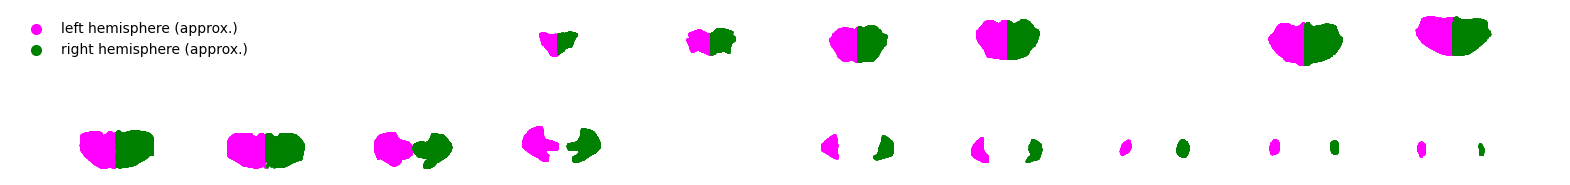

In [6]:
# Sanity check that our approx. method of detecting the midline work okay
fig = plt.figure(figsize=(20,8))

# for sec in adata_brain3.obs['section'].unique():
ax = plt.gca()

# plot left vs right cells in different colors
ax.scatter(left_hemi_ad.obsm['spatial_cirro'][:,0], 
           left_hemi_ad.obsm['spatial_cirro'][:,1],
           c='magenta', s=1, label='left hemisphere (approx.)')
ax.scatter(right_hemi_ad.obsm['spatial_cirro'][:,0], 
           right_hemi_ad.obsm['spatial_cirro'][:,1],
           c='green', s=1, label='right hemisphere (approx.)')
ax.set_aspect('equal', 'box')
ax.legend(loc='upper left', markerscale=7, frameon=False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.spines[['top', 'bottom', 'right', 'left']].set_visible(False)

# L vs R metrics

In [7]:
sec_ids = adata_brain3.obs['section'].unique().tolist()

# Store metrics in a per-section dataframe
sec_properties_df = pd.DataFrame(index=sec_ids)

## total # of cells in L vs R hemisphere

### calculate

In [8]:
# Count the number of cells in each hemisphere
for sec in sec_ids:
    n_cells_left = sum((adata_brain3.obs['section']==sec) & 
                       (adata_brain3.obs['left_right']=='left')
                      )
    n_cells_right = sum((adata_brain3.obs['section']==sec) & 
                        (adata_brain3.obs['left_right']=='right')
                       )
    n_cells_pct_diff = (abs(n_cells_left - n_cells_right) / ((n_cells_left + n_cells_right) / 2)) * 100
    
    sec_properties_df.loc[sec,'n_cells_left'] = n_cells_left
    sec_properties_df.loc[sec,'n_cells_right'] = n_cells_right
    sec_properties_df.loc[sec,'n_cells_pct_diff'] = n_cells_pct_diff
    

sec_properties_df['n_cells_left'] = sec_properties_df['n_cells_left'].astype(int)
sec_properties_df['n_cells_right'] = sec_properties_df['n_cells_right'].astype(int)

### plot

In [9]:
sns.color_palette("hls", len(sec_ids))

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.5791999999999999, 0.33999999999999997),
 (0.86, 0.7872, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.5167999999999999, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.3712),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.86, 0.7872000000000001),
 (0.33999999999999997, 0.7247999999999999, 0.86),
 (0.33999999999999997, 0.5167999999999999, 0.86),
 (0.3712, 0.33999999999999997, 0.86),
 (0.5791999999999999, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.7247999999999996),
 (0.86, 0.33999999999999997, 0.5167999999999995)]

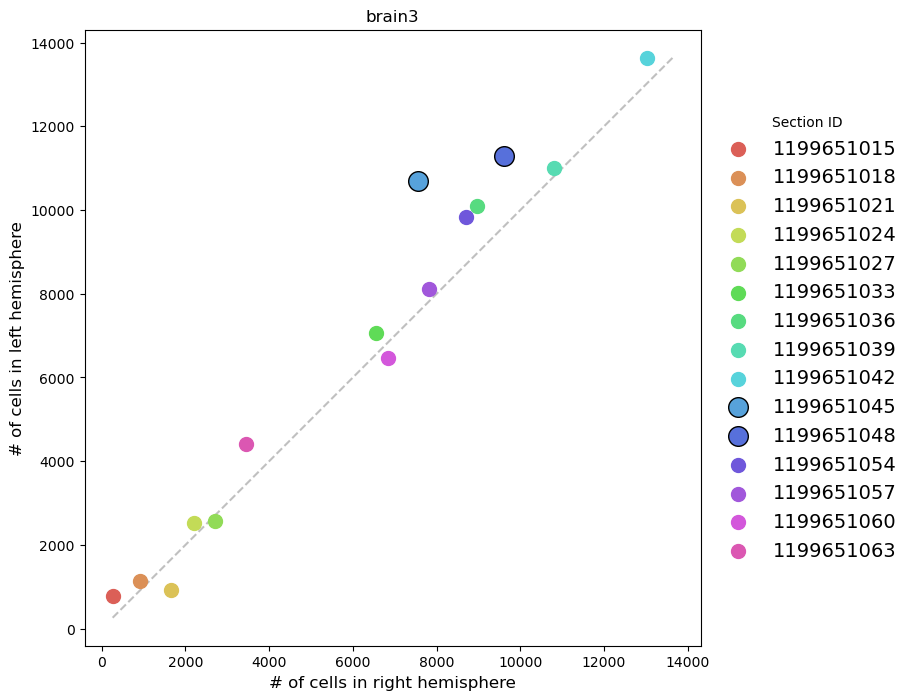

In [10]:
# Plot L vs R total # of cells per hemisphere
fig, ax = plt.subplots(figsize=(8,8))

colors = sns.color_palette("hls", len(sec_ids)+1)


xymin = np.min([sec_properties_df['n_cells_left'].min(), 
               sec_properties_df['n_cells_right'].min()])
xymax = np.max([sec_properties_df['n_cells_left'].max(), 
               sec_properties_df['n_cells_right'].max()])
ax.plot([xymin,xymax], [xymin,xymax], color='silver', linestyle='--',zorder=0)

for i in range(len(sec_properties_df)):
    # highlight the two problematic sections
    if sec_ids[i] in ['1199651045', '1199651048']:
        ax.scatter(sec_properties_df['n_cells_right'][i], 
                   sec_properties_df['n_cells_left'][i], 
                   s=200, color=colors[i], label=sec_ids[i],
                   edgecolors='black')
    else:
        ax.scatter(sec_properties_df['n_cells_right'][i], 
                   sec_properties_df['n_cells_left'][i], 
                   s=100, color=colors[i], label=sec_ids[i])

# Create a legend for all the scatter points
ax.set_aspect('equal', 'box')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(loc="center left", bbox_to_anchor=(1.,0.5), title="Section ID", 
          fontsize=14, frameon=False)

ax.set_xlabel('# of cells in right hemisphere', fontsize=12)
ax.set_ylabel('# of cells in left hemisphere', fontsize=12)
plt.title('brain3')
plt.show()

## Gene expression based metrics

total reads, mean expression, median expression, 95th & 99th percentile expression, number of cells expressing, fraction of cells expressing

### calculate expression metrics

In [11]:
# dictionary to store each section's metrics as a separate, gene-by-metric df
section_LR_properties = {}

# Calculate all the gene expression-based metrics
for sec in sec_ids:
    gene_expr_left = adata_brain3[(adata_brain3.obs['section']==sec) & 
                                  (adata_brain3.obs['left_right']=='left')].X.A
    gene_expr_right = adata_brain3[(adata_brain3.obs['section']==sec) & 
                                   (adata_brain3.obs['left_right']=='right')].X.A
    
    # Calculate the number of cells in sec_adata_left and sec_adata_right
    num_cells_left = gene_expr_left.shape[0]
    num_cells_right = gene_expr_right.shape[0]
    
    # Calculate expression metrics for each gene (gene axis=0)
    # total reads
    total_reads_left = np.sum(gene_expr_left, axis=0)
    total_reads_right = np.sum(gene_expr_right, axis=0)
    # mean
    mean_left = np.mean(gene_expr_left, axis=0)
    mean_right = np.mean(gene_expr_right, axis=0)
    # median
    median_left = np.median(gene_expr_left, axis=0)
    median_right = np.median(gene_expr_right, axis=0)
    # 95th percentile expression
    pct = 95
    pct95_left = np.percentile(gene_expr_left, q=pct, axis=0)
    pct95_right = np.percentile(gene_expr_right, q=pct, axis=0)
    # 99th percentile expression
    pct = 95
    pct99_left = np.percentile(gene_expr_left, q=pct, axis=0)
    pct99_right = np.percentile(gene_expr_right, q=pct, axis=0)
    # number of cells expressing each gene
    n_cells_expr_left = np.sum(gene_expr_left > 0, axis=0)
    n_cells_expr_right = np.sum(gene_expr_right > 0, axis=0)
    
    # Create a dictionary to store the results
    gene_data = {
                 # total reads
                 'total_reads_left': total_reads_left,
                 'total_reads_right': total_reads_right,
                 # mean
                 'mean_left': mean_left,
                 'mean_right': mean_right,
                 'mean_left_per_cell': mean_left / num_cells_left,
                 'mean_right_per_cell': mean_right / num_cells_right,
                 # median
                 'median_left': median_left,
                 'median_right': median_right,
                 'median_left_per_cell': median_left / num_cells_left,
                 'median_right_per_cell': median_right / num_cells_right,
                 # 95th percentile
                 '95pct_left': pct95_left,
                 '95pct_right': pct95_right,
                 '95pct_left_per_cell': pct95_left / num_cells_left,
                 '95pct_right_per_cell': pct95_right / num_cells_right,
                 # 99th percentile
                 '99pct_left': pct99_left,
                 '99pct_right': pct99_right,
                 '99pct_left_per_cell': pct99_left / num_cells_left,
                 '99pct_right_per_cell': pct99_right / num_cells_right,
                 # fraction of cells that are expressing
                 'n_cells_expr_left': n_cells_expr_left,
                 'n_cells_expr_right': n_cells_expr_right,
                 'frac_cells_expr_left': n_cells_expr_left / num_cells_left,
                 'frac_cells_expr_right': n_cells_expr_right / num_cells_right
                }

    # Convert the dictionary to a DataFrame
    sec_df = pd.DataFrame(gene_data, index=genes)
    
    # Add to per-section dictionary
    section_LR_properties[sec] = sec_df
    
# section_LR_properties

In [12]:
# # uncomment to see the format of this df
# section_LR_properties['1199651048']

### plot_left_vs_right_hemisphere_metric()

In [13]:
def plot_left_vs_right_hemisphere_metric(section_LR_properties, sec_ids, 
                                         property_col_left, property_col_right,
                                         property_name_str, genes_to_highlight=[], 
                                         xymin=None, xymax=None):
    '''
    Plot left vs right hemisphere metrics.
    
    Parameters
    ----------
    section_LR_properties: dictionary of Pandas dataframes
        as generated earlier in this notebook
    
    sec_ids: list of strings
        IDs of sections to generate plots for
    
    property_col_left, property_col_right:
        name of df columns to plot
    
    property_name_str: string
        name of the property as you want it to appear as the title of the plot
        
    genes_to_highlight: list of strings
        names of genes that will be plotted larger & in a different color
        
    Returns
    ------
    fig: Matplotlib figure
    
    '''
    
    fig, axs = plt.subplots(1, 4, figsize=(24, 7))
    plt.subplots_adjust(wspace=0.2)

    for i, sec_id_str in enumerate(sec_ids):
        # get the current section from the dictionary
        sec_df = section_LR_properties[sec_id_str]
        genes = sec_df.index.tolist()

        ax = axs[i]  # Select the current subplot

        ax.scatter(sec_df.loc[:, property_col_right], 
                   sec_df.loc[:, property_col_left],
                   s=10, zorder=0, alpha=0.5, label='brain3 genes')

        for gene in genes:
            # highlight specified genes - larger, different colors, labeled
            if gene in genes_to_highlight:
                ax.scatter(sec_df.loc[gene, property_col_right], 
                           sec_df.loc[gene, property_col_left],
                           s=200, zorder=3, label=gene, edgecolors='k')
        # only show legend for leftmost plot (no need to plot more than once)
        if i==0:
            ax.legend(loc='lower left', bbox_to_anchor=(0.1,1.1), ncol=2,
                      frameon=True, fontsize=14)
        # other plot parameters    
        ax.set_aspect('equal', 'box')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('right hemisphere', fontsize=16)
        ax.set_ylabel('left hemisphere', fontsize=16)
        ax.set_xlim(xymin, xymax)
        ax.set_ylim(xymin, xymax)
        ax.plot([0, xymax], [0, xymax], color='k', linestyle='--', zorder=2) # tuck 1:1 line behind highlighted genes
        ax.set_title('section ' + sec_id_str, fontsize=16)
    
    plt.suptitle(property_name_str, fontsize=20)
    plt.tight_layout() #rect=[0, 0.03, 1, 0.95])  # set aside space for suptitle
    plt.show()
    
    return fig

### set plotting parameters

In [14]:
genes_to_highlight = ['Bnc1', 'Cldn5', 'Lpar1', 'Nrp1', # noticeably asymmetric, 'Whrn'
                      'Pou6f2', 'St6galnac5' # not very noticeable
                     ]

# list anterior to posterior to match gene expression scatter plots
sec_to_plot = [
               '1199651054', # reasonable-looking section for comparison
               '1199651048', # problematic section
               '1199651045', # problematic section
               '1199651042'  # reasonable-looking section for comparison
              ]

### plot expression metrics

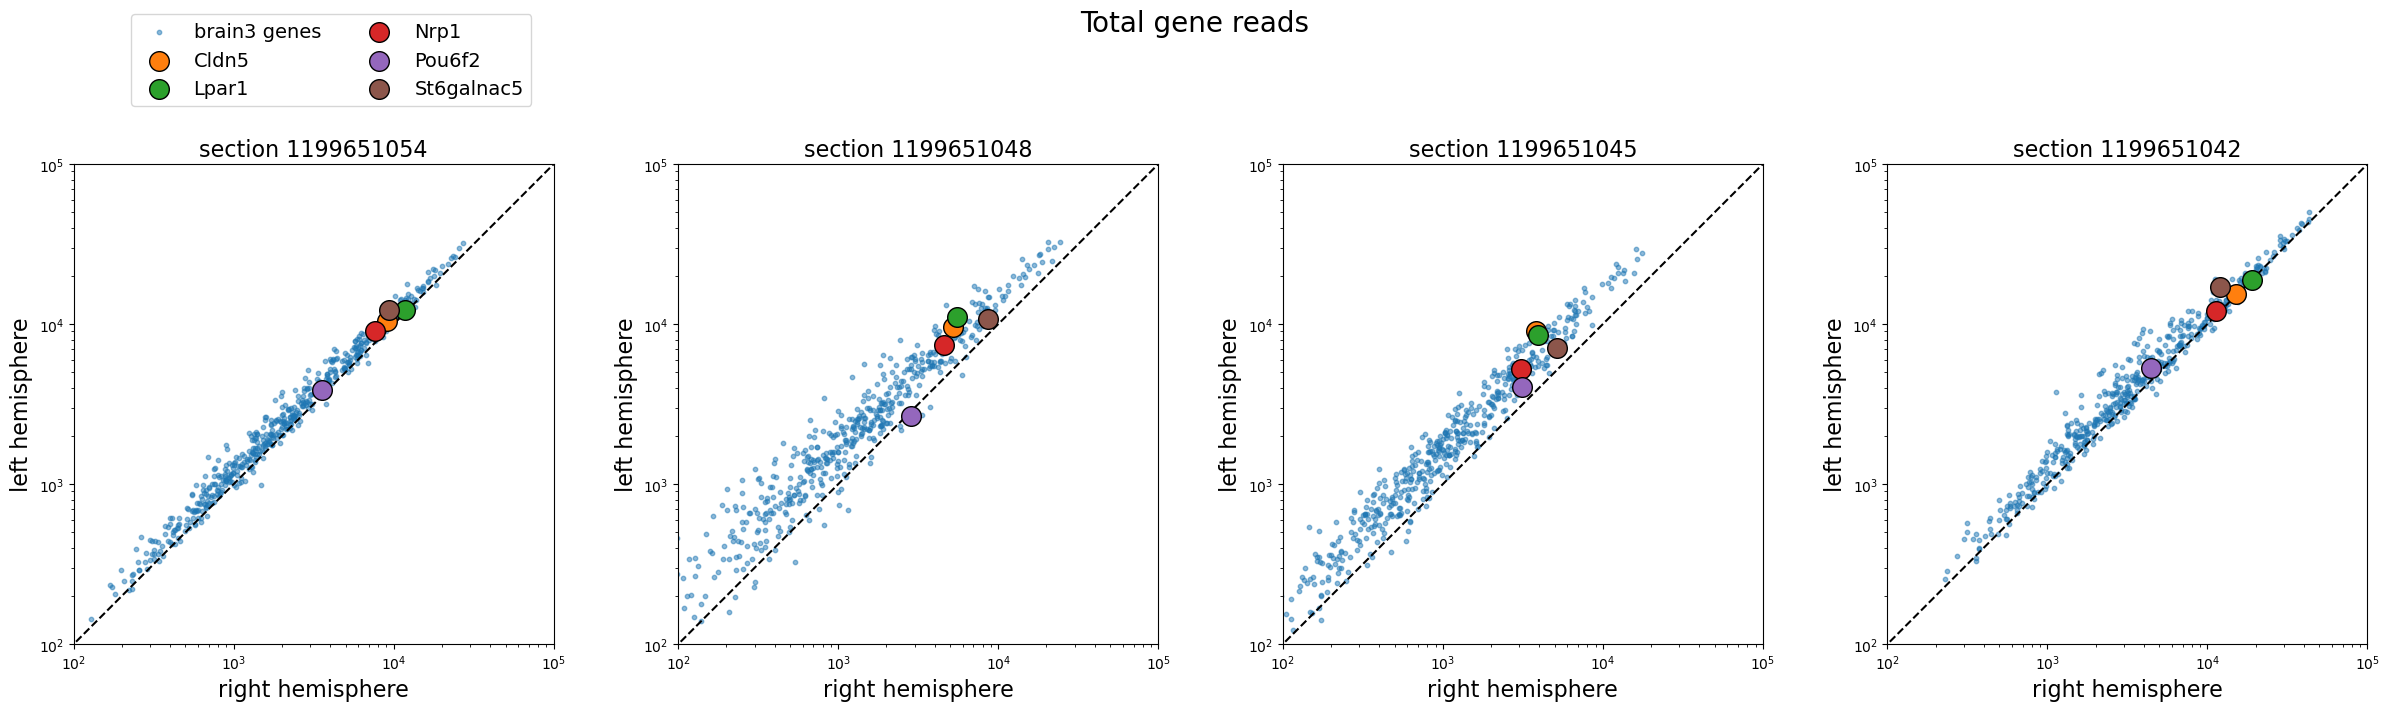

In [15]:
# Total gene reads
property_col_left = 'total_reads_left'
property_col_right = 'total_reads_right'
property_name = 'Total gene reads'

fig_tot_reads = plot_left_vs_right_hemisphere_metric(section_LR_properties, 
                                                     sec_to_plot, 
                                                     property_col_left, 
                                                     property_col_right,
                                                     property_name, 
                                                     genes_to_highlight=genes_to_highlight,
                                                     xymin=100,xymax=100000)

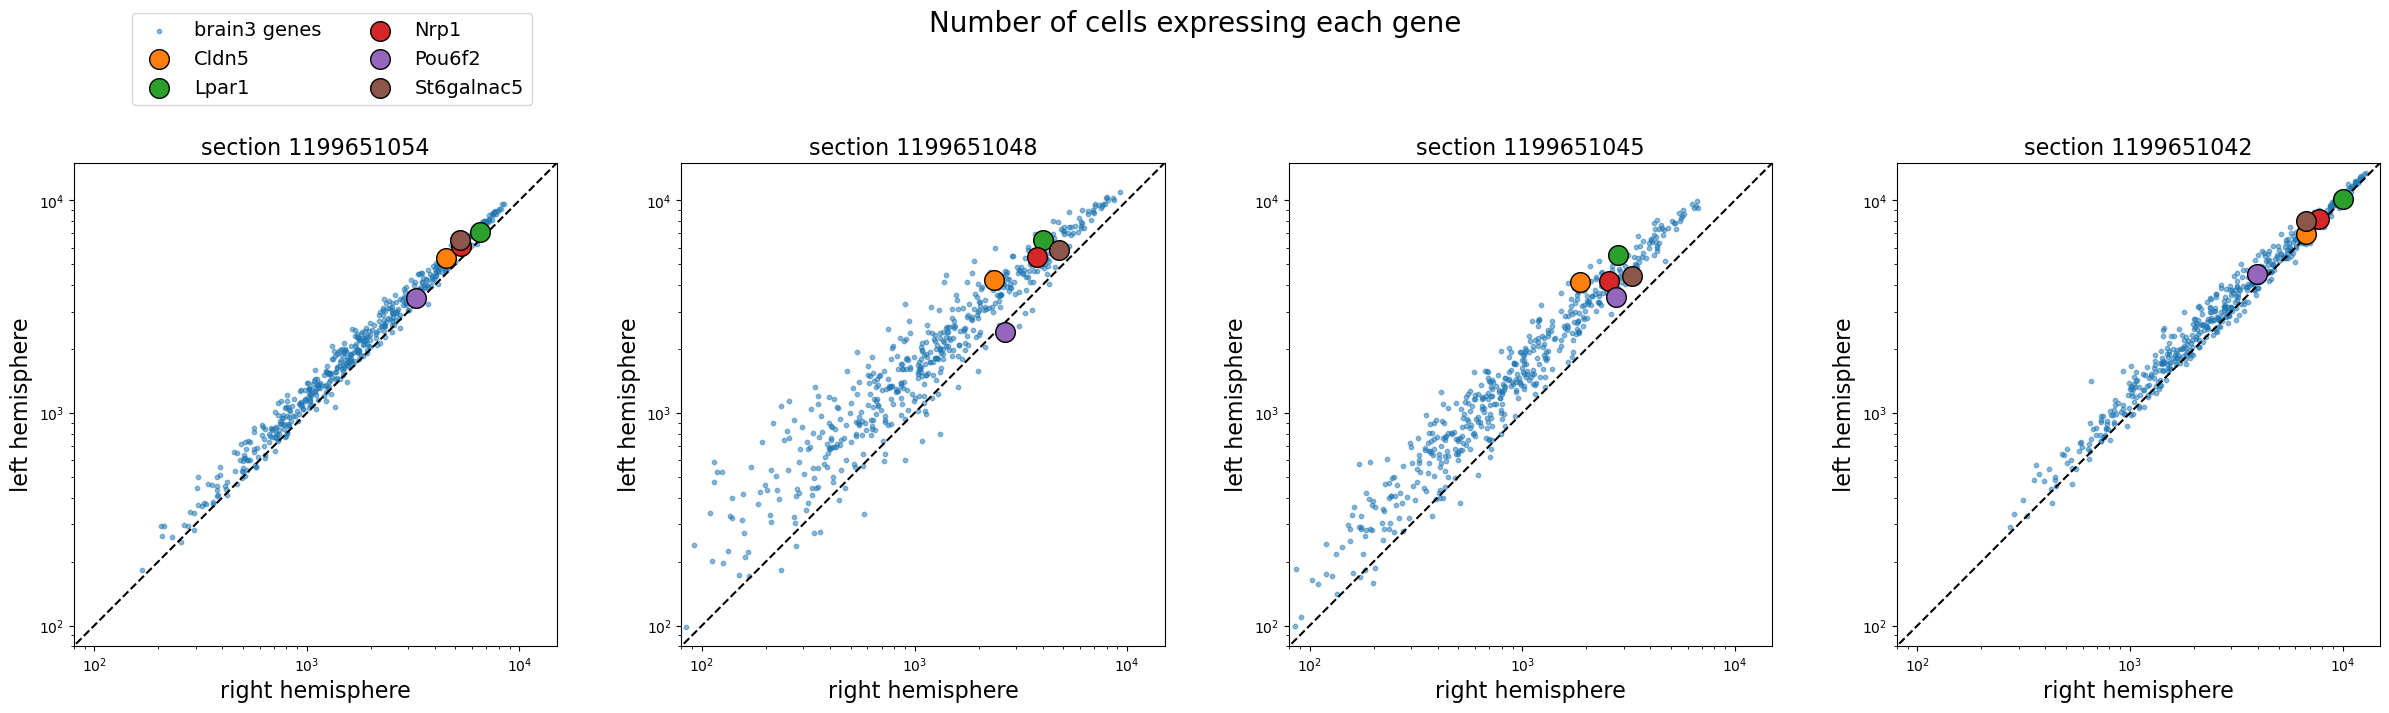

In [16]:
# Total number of cells expressing each gene
property_col_left = 'n_cells_expr_left'
property_col_right = 'n_cells_expr_right'
property_name = 'Number of cells expressing each gene'

fig_cells_expr = plot_left_vs_right_hemisphere_metric(section_LR_properties, 
                                                      sec_to_plot, 
                                                      property_col_left, 
                                                      property_col_right,
                                                      property_name, 
                                                      genes_to_highlight=genes_to_highlight,
                                                      xymin=80,xymax=15000)

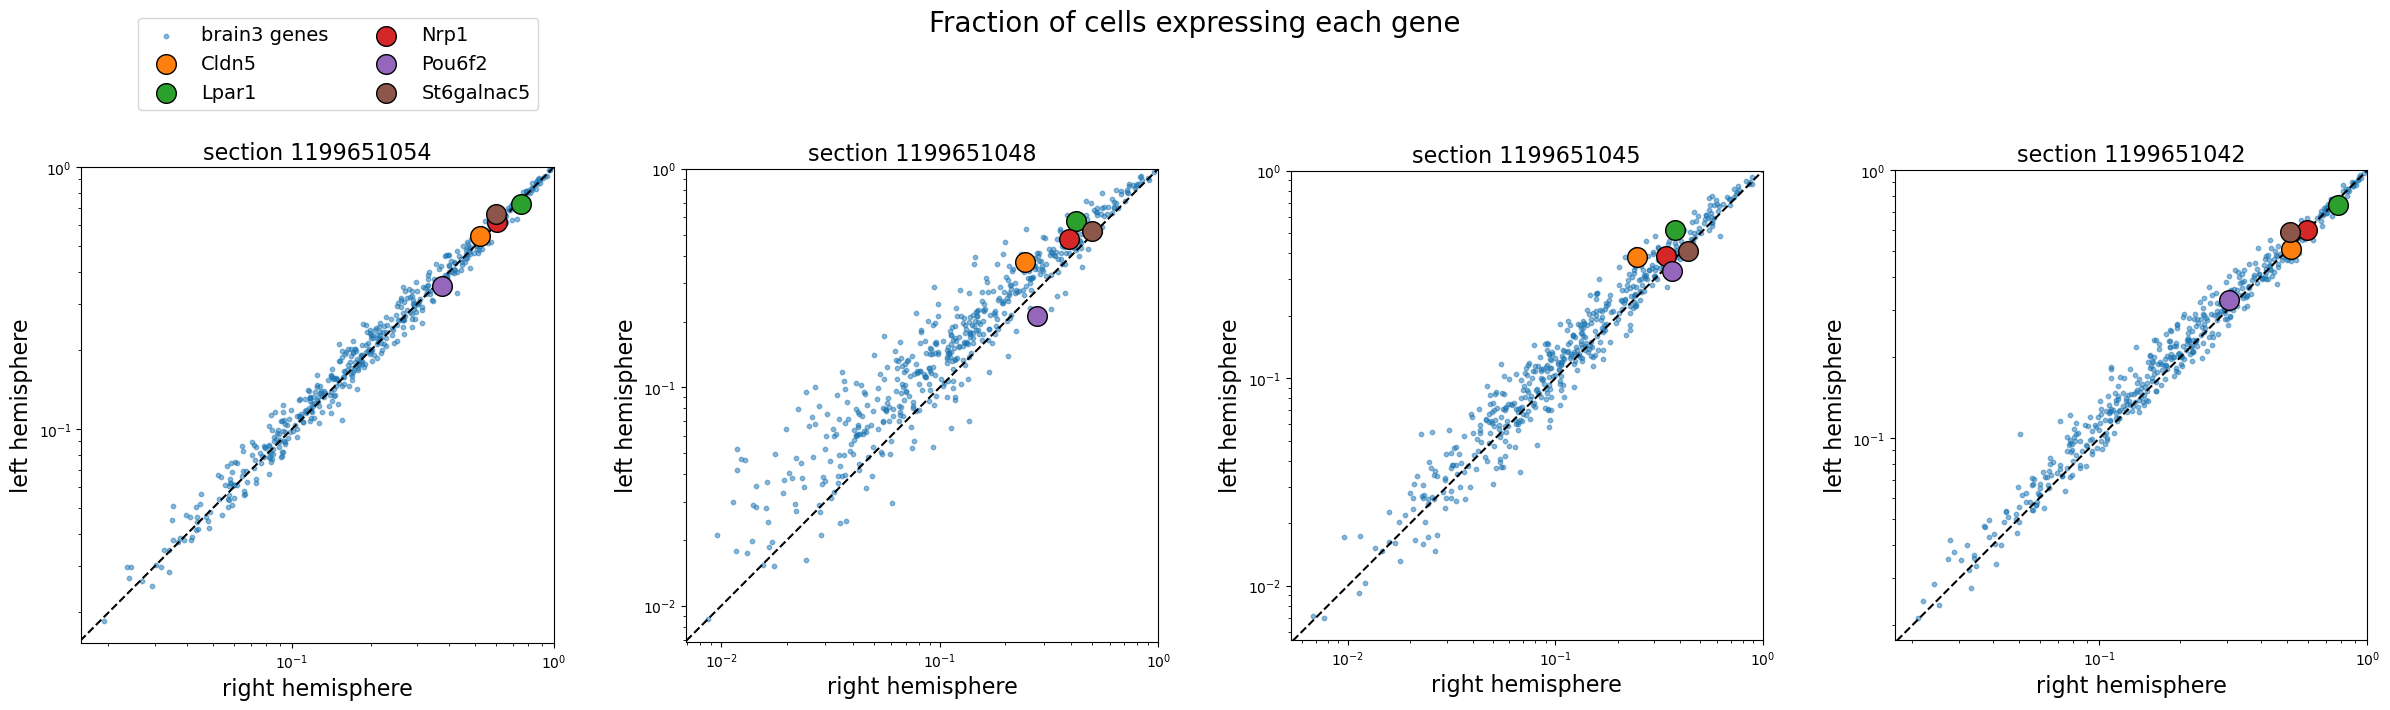

In [17]:
# Fraction of cells expressing each gene
property_col_left = 'frac_cells_expr_left'
property_col_right = 'frac_cells_expr_right'
property_name = 'Fraction of cells expressing each gene'

fig_frac_expr = plot_left_vs_right_hemisphere_metric(section_LR_properties, 
                                                     sec_to_plot, 
                                                     property_col_left, 
                                                     property_col_right,
                                                     property_name, 
                                                     genes_to_highlight=genes_to_highlight,
                                                     xymax=1)

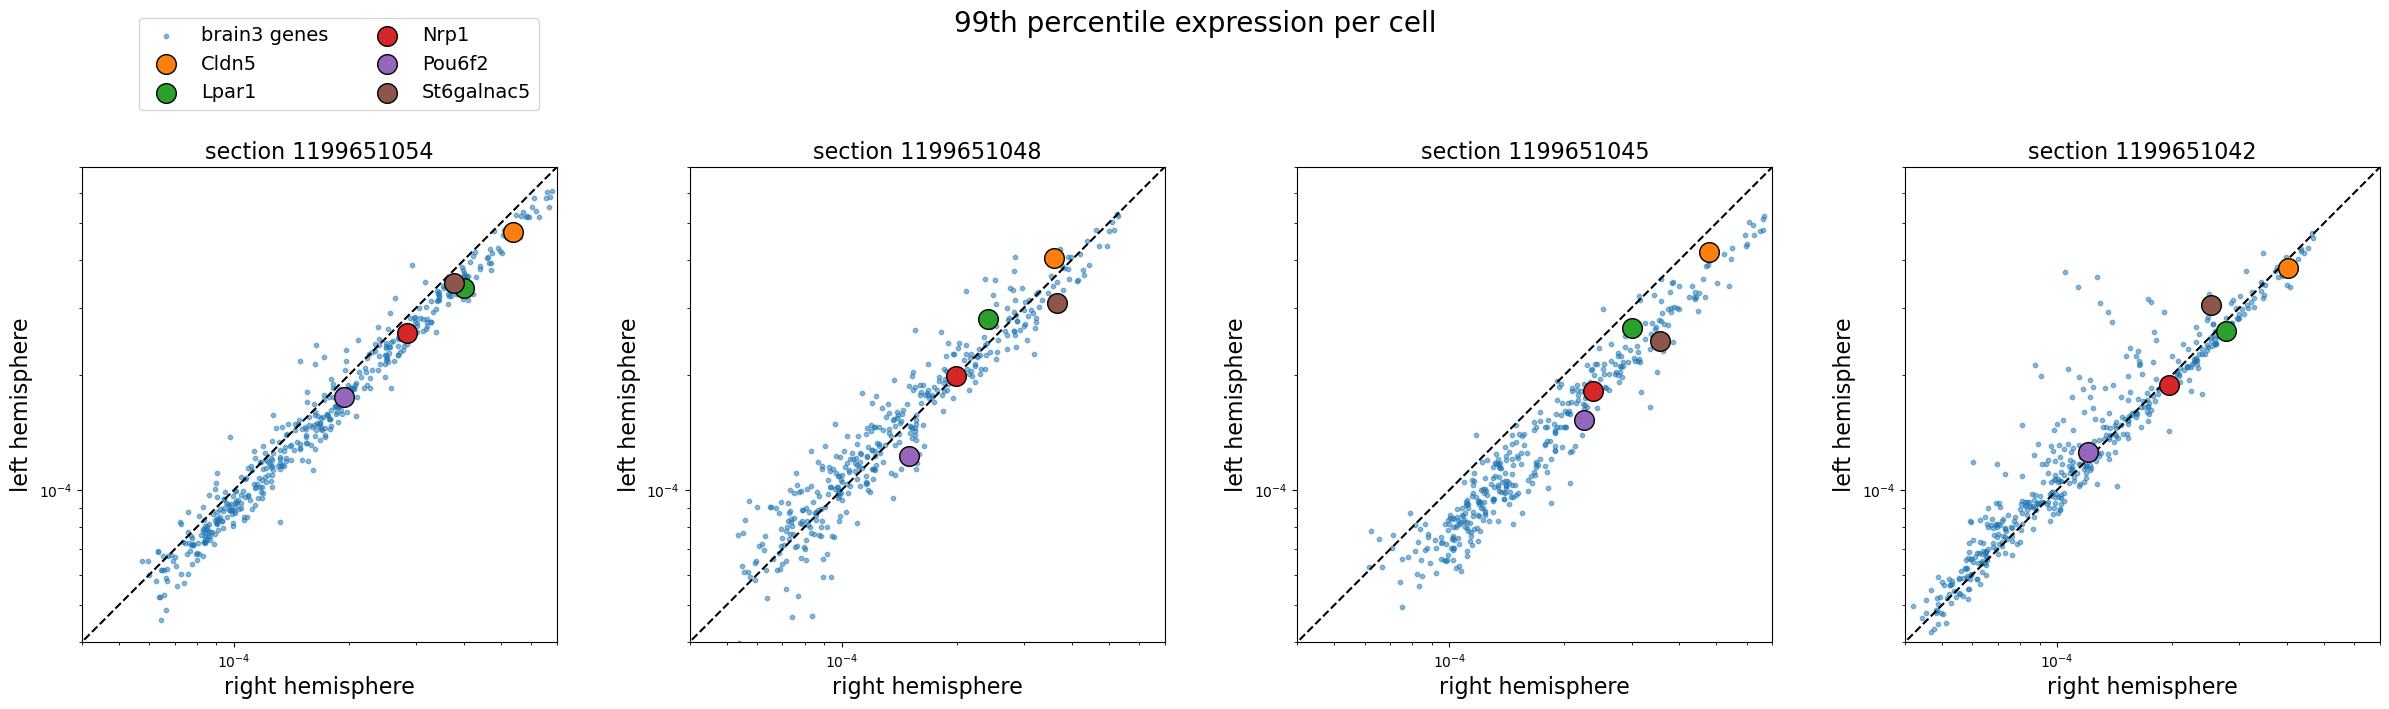

In [18]:
# 99th percentile gene expression, normalized per cell
property_col_left = '99pct_left_per_cell'
property_col_right = '99pct_right_per_cell'
property_name = '99th percentile expression per cell'

# for sec in sec_to_plot:
fig_99pct = plot_left_vs_right_hemisphere_metric(section_LR_properties, 
                                                 sec_to_plot, 
                                                 property_col_left, 
                                                 property_col_right,
                                                 property_name, 
                                                 genes_to_highlight=genes_to_highlight,
                                                 xymin=0.00004, xymax=0.0007)

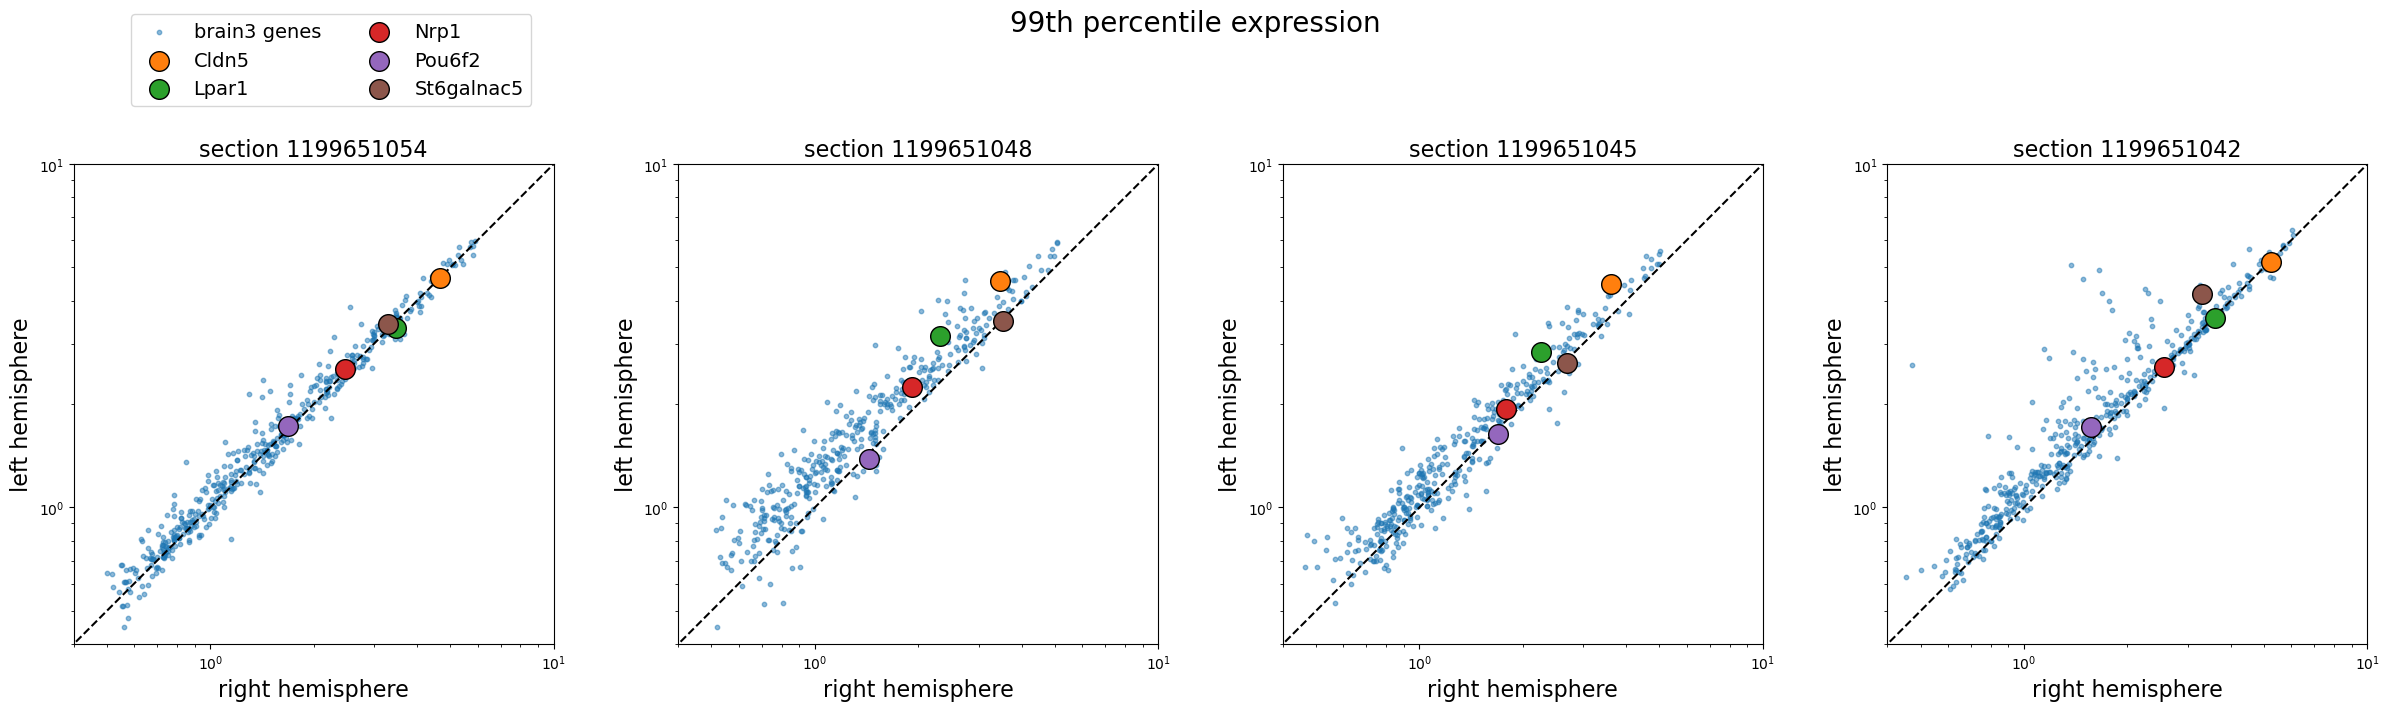

In [19]:
# 99th percentile gene expression, not normalized
property_col_left = '99pct_left'
property_col_right = '99pct_right'
property_name = '99th percentile expression'

# for sec in sec_to_plot:
fig_99pct_norm = plot_left_vs_right_hemisphere_metric(section_LR_properties, 
                                                      sec_to_plot, 
                                                      property_col_left, 
                                                      property_col_right,
                                                      property_name, 
                                                      genes_to_highlight=genes_to_highlight,
                                                      xymin=0.4, xymax=10)

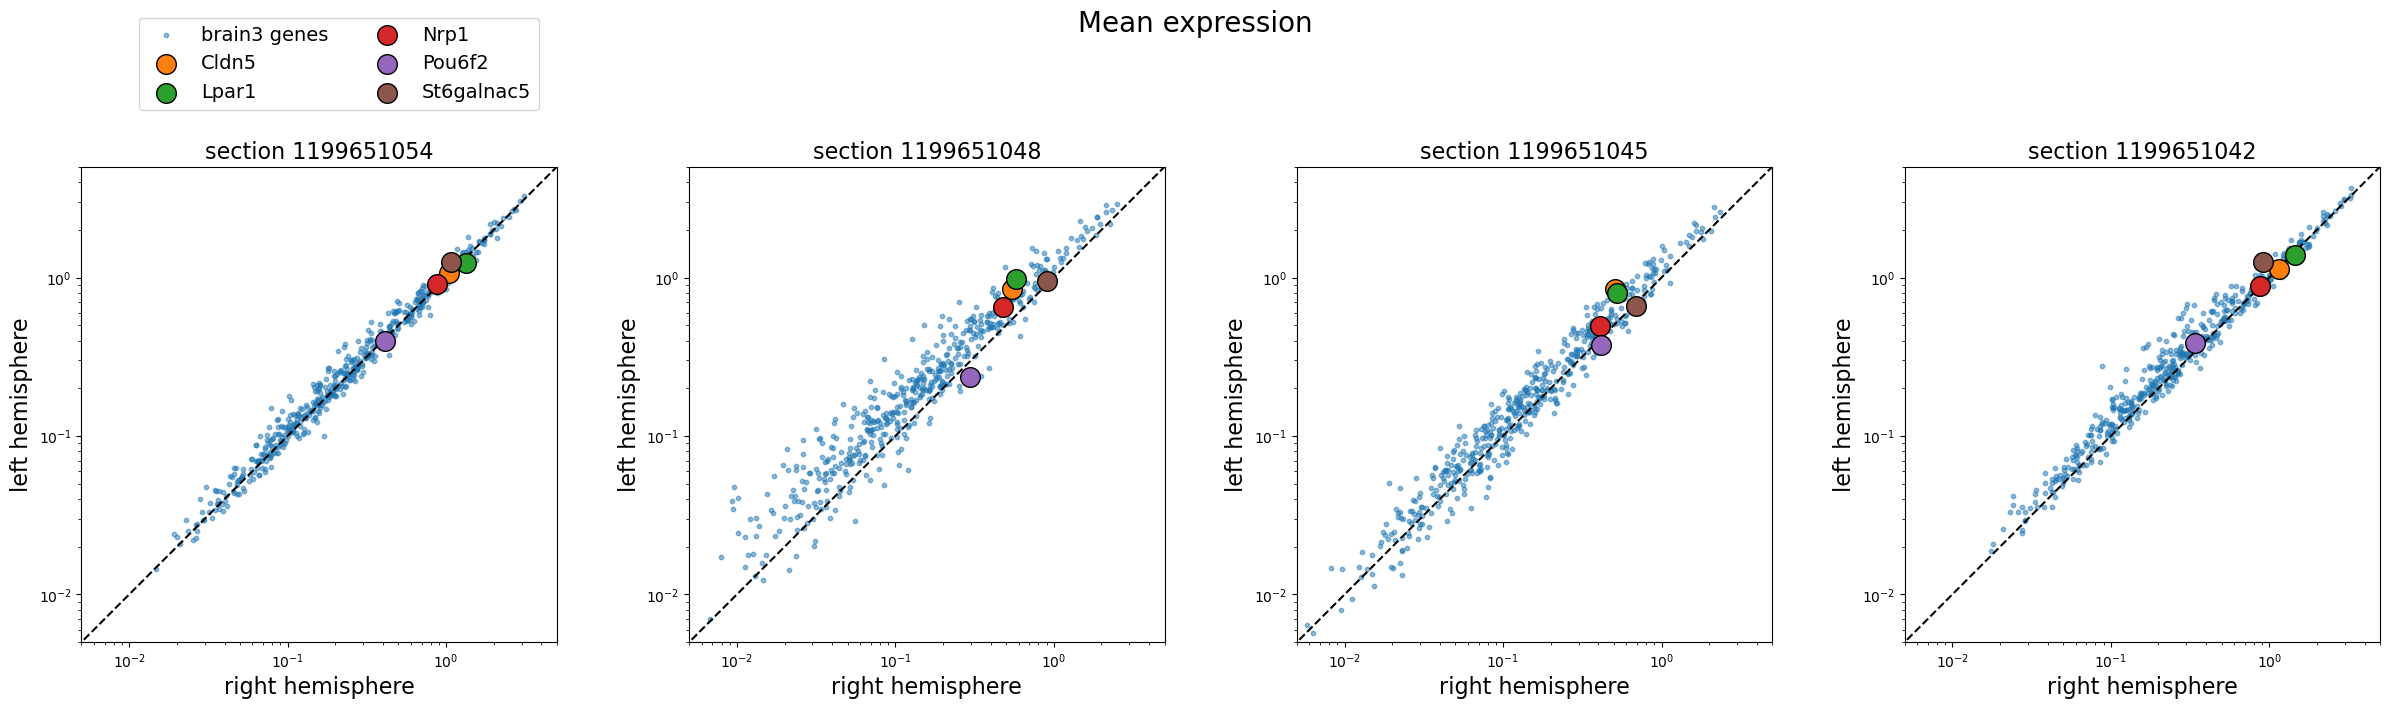

In [20]:
# Mean gene expression, not normalized
property_col_left = 'mean_left'
property_col_right = 'mean_right'
property_name = 'Mean expression'

# for sec in sec_to_plot:
fig_mean = plot_left_vs_right_hemisphere_metric(section_LR_properties, 
                                                sec_to_plot, 
                                                property_col_left, 
                                                property_col_right,
                                                property_name, 
                                                genes_to_highlight=genes_to_highlight,
                                                xymin=0.005, xymax=5)

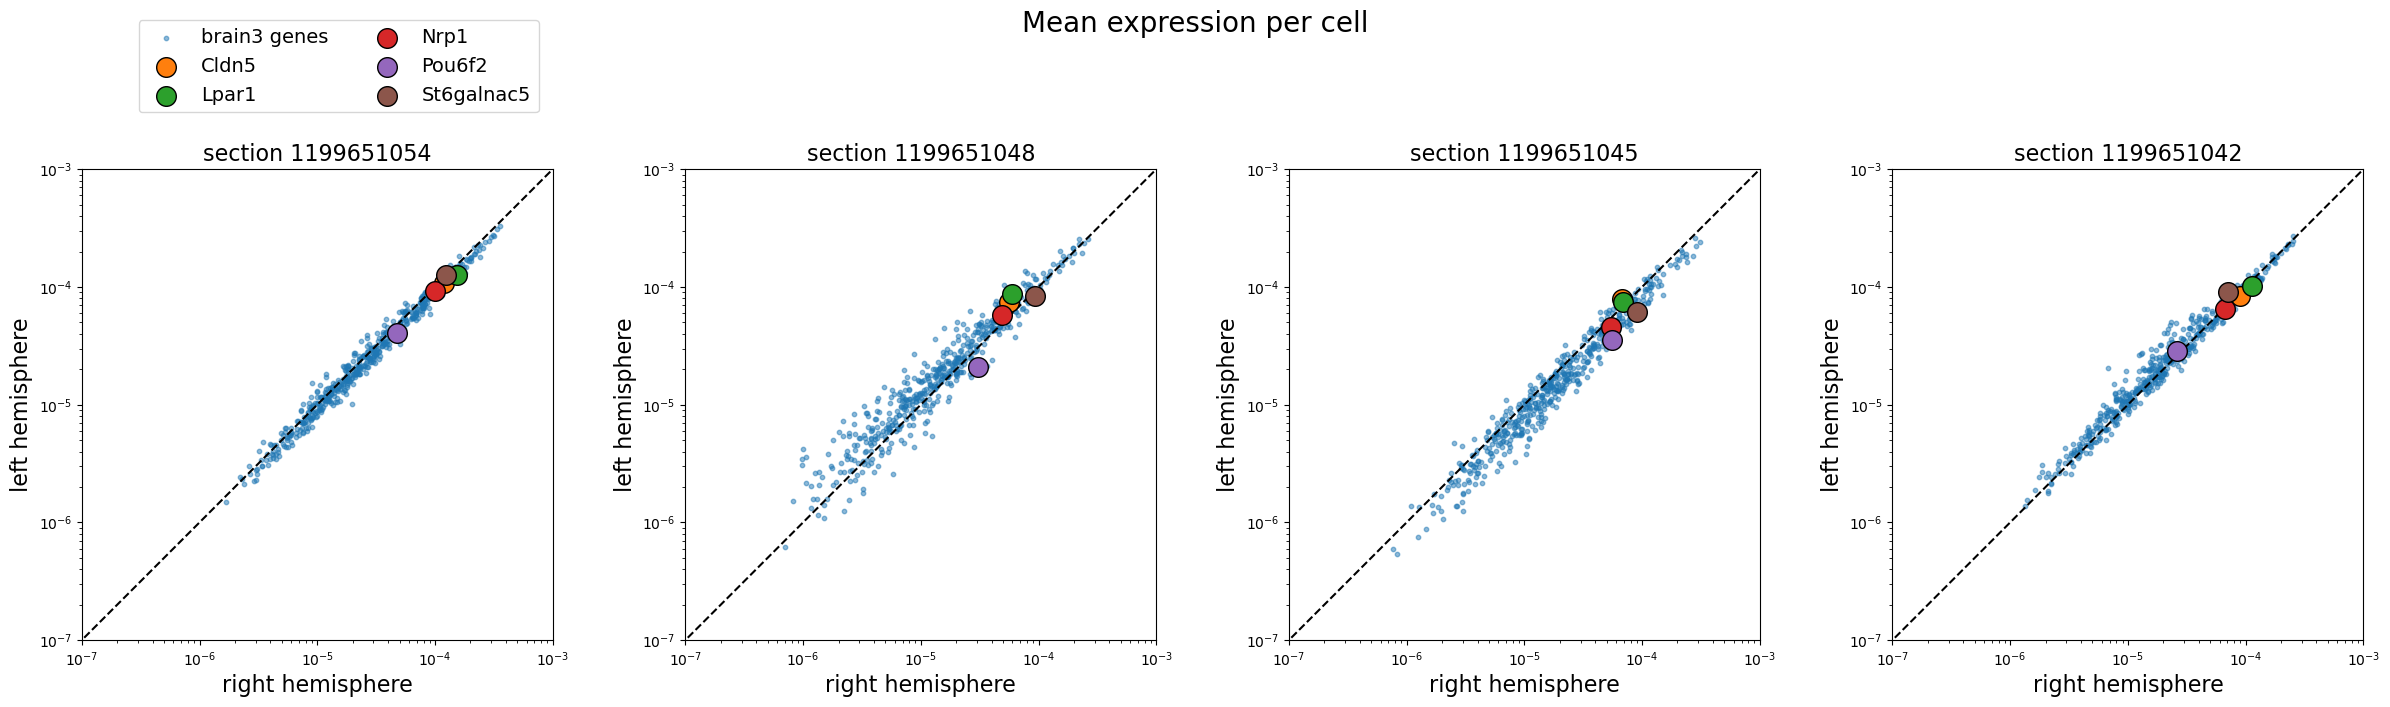

In [21]:
# Mean gene expression, normalized per cell
property_col_left = 'mean_left_per_cell'
property_col_right = 'mean_right_per_cell'
property_name = 'Mean expression per cell'

# for sec in sec_to_plot:
fig_mean_norm = plot_left_vs_right_hemisphere_metric(section_LR_properties, 
                                                     sec_to_plot, 
                                                     property_col_left, 
                                                     property_col_right,
                                                     property_name, 
                                                     genes_to_highlight=genes_to_highlight,
                                                     xymin=0.0000001, xymax=0.001)